In [1]:
import haversine as hs
from haversine import Unit
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import re
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import covariance
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
import warnings
from itertools import combinations
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import kneighbors_graph
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error
import cvxpy as cp



### Dataset 

In [2]:
# sonotypes matrix: X
df1 = pd.read_excel(r'Data/Acoustic_structures_matrix.xlsx') #acoustic structure matrix
df2 = df1.iloc[:,1:]
df2

,2,3,4,5,6,7,8,9,10,11,...,346,348,349,351,352,353,354,355,356,358
0,2147,5991,965,2070,13,11267,2588,13203,370,372,...,178,68,38,25,51,33,2,1,1,17
1,1733,4502,637,2110,50,2307,1232,5179,91,65,...,140,99,37,54,129,43,0,0,1,21
2,640,5983,704,6192,0,13213,151,6781,900,54,...,143,191,20,46,16,34,1,1,0,21
3,450,6319,359,4335,0,10314,516,9410,627,289,...,181,147,42,39,80,33,1,1,3,32
4,391,9177,468,1416,0,2120,846,1809,213,1538,...,214,284,38,112,49,135,1,1,2,64
5,751,7728,330,675,2,12486,401,5930,1261,2072,...,80,245,32,153,64,48,5,4,2,41
6,776,12360,1500,1604,5,15887,692,8396,1237,2925,...,168,121,19,96,123,38,11,0,2,37
7,535,8602,490,543,1,5782,634,4752,760,1133,...,192,102,30,95,114,87,8,0,1,29
8,698,4911,252,2953,14,9522,647,6002,234,1487,...,307,176,26,66,77,87,0,1,0,24
9,52,4394,88,6,0,2430,8,513,68,0,...,212,93,4,50,80,23,0,0,3,18


In [3]:
# Normalize
scaler = MinMaxScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

df_norm

,2,3,4,5,6,7,8,9,10,11,...,346,348,349,351,352,353,354,355,356,358
0,1.000000,0.167103,0.396474,0.333657,0.26,0.664415,0.865481,1.000000,0.278543,0.127179,...,0.115976,0.009174,0.539683,0.000000,0.141844,0.198529,0.181818,0.25,0.333333,0.088889
1,0.804440,0.011301,0.248192,0.340123,1.00,0.013583,0.410600,0.367691,0.052632,0.022222,...,0.071006,0.151376,0.523810,0.226562,0.418440,0.272059,0.000000,0.00,0.333333,0.133333
2,0.288144,0.166266,0.278481,1.000000,0.00,0.805767,0.047970,0.493932,0.707692,0.018462,...,0.074556,0.573394,0.253968,0.164062,0.017730,0.205882,0.090909,0.25,0.000000,0.133333
3,0.198394,0.201423,0.122514,0.699806,0.00,0.595191,0.170413,0.701103,0.486640,0.098803,...,0.119527,0.371560,0.603175,0.109375,0.244681,0.198529,0.090909,0.25,1.000000,0.255556
4,0.170524,0.500471,0.171790,0.227934,0.00,0.000000,0.281114,0.102128,0.151417,0.525812,...,0.158580,1.000000,0.539683,0.679688,0.134752,0.948529,0.090909,0.25,0.666667,0.611111
5,0.340576,0.348854,0.109403,0.108147,0.04,0.752960,0.131835,0.426872,1.000000,0.708376,...,0.000000,0.821101,0.444444,1.000000,0.187943,0.308824,0.454545,1.00,0.666667,0.355556
6,0.352385,0.833525,0.638336,0.258325,0.10,1.000000,0.229453,0.621198,0.980567,1.000000,...,0.104142,0.252294,0.238095,0.554688,0.397163,0.235294,1.000000,0.00,0.666667,0.311111
7,0.238545,0.440306,0.181736,0.086809,0.02,0.265998,0.209997,0.334043,0.594332,0.387350,...,0.132544,0.165138,0.412698,0.546875,0.365248,0.595588,0.727273,0.00,0.333333,0.222222
8,0.315541,0.054096,0.074141,0.476398,0.28,0.537663,0.214358,0.432545,0.168421,0.508376,...,0.268639,0.504587,0.349206,0.320312,0.234043,0.595588,0.000000,0.25,0.000000,0.166667
9,0.010392,0.000000,0.000000,0.000000,0.00,0.022518,0.000000,0.000000,0.034008,0.000000,...,0.156213,0.123853,0.000000,0.195312,0.244681,0.125000,0.000000,0.00,1.000000,0.100000


In [4]:
# site information 
df = pd.read_excel(r'/Data/Matrix_information.xlsx')
df

,Point,latitude,longitude,Habitat,Site,Recording Name
0,KLSA01,7.36574,-73.85669,1,0,SMA03286
1,KLSA02,7.36832,-73.86041,1,1,SMA03294
2,KLSA03,7.36765,-73.85181,2,2,SMA03332
3,KLSA04,7.36233,-73.85412,1,3,SMA03322
4,KLSA05,7.36389,-73.86101,3,4,SMA03210
5,KLSA06,7.36238,-73.84993,1,5,SMA03328
6,KLSA07,7.35796,-73.85642,3,6,SMA03297
7,KLSA08,7.36733,-73.86392,1,7,SMA03175ICP
8,KLSA09,7.35986,-73.86059,1,8,SMA03247
9,KLSA10,7.36400,-73.87019,2,9,SMA03327


### Graph inference Models

In [5]:
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)) 
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [6]:
def minmax_adjacency(A, keep_zeros=True, force_symmetric=True):
    """
     Min-max normalizes A to [0,1].
    - keep_zeros=True: keeps 0 where there is no link.
    - force_symmetric=True: symmetrize A as(A + A^T)/2.
    """
    A = np.asarray(A, dtype=float)
    if force_symmetric:
        A = 0.5 * (A + A.T)

    if keep_zeros:
        mask = (A != 0)
        if np.any(mask):
            w = A[mask]
            w_min, w_max = w.min(), w.max()
            A_norm = np.zeros_like(A)
            if w_max > w_min:
                A_norm[mask] = (A[mask] - w_min) / (w_max - w_min)
            else:
                # todos los enlaces no-cero tenían el mismo peso
                A_norm[mask] = 1.0
        else:
            A_norm = A.copy()  # todo cero
    else:
        w_min, w_max = A.min(), A.max()
        if w_max > w_min:
            A_norm = (A - w_min) / (w_max - w_min)
        else:
            A_norm = np.zeros_like(A)

    np.fill_diagonal(A_norm, 0.0)  # sin auto-bucles
    return A_norm

In [7]:
def plot_network(matrix, threshold, same_position_data_func, df_info,
                 savepath=None, figsize=(10, 8), dpi=300, transparent=False,
                 title=None, show=True):
    """
    matrix: DataFrame n×n with weights (indexes/columns = node ids)
    threshold: float, threshold to filter |weight| of edges
    same_position_data_func: function that receives df_info and returns coords per node
    df_info:   DataFrame with column 'Habitat' (aligned 0..n-1)
    savepath: str or None. If ends in '.svg' will save SVG, etc.
    figsize: figure size
    dpi: resolution on save (for raster: png/jpg/tiff)
    transparent: transparent background on save
    title: optional title drawn on top
    show: if True, does plt.show() at the end

    Returns: (G_filtered, G_complete, fig, ax)
    """
    links = matrix.stack().reset_index()
    links.columns = ['var1', 'var2', 'value']
    links2 = links.copy()

    links = links.loc[(np.abs(links['value']) >= threshold) & (links['var1'] != links['var2'])]
    links2 = links2.loc[(links2['var1'] != links2['var2'])]

    G = nx.from_pandas_edgelist(links, 'var1', 'var2', edge_attr='value', create_using=nx.Graph())
    all_nodes = pd.Series(pd.concat([links2['var1'], links2['var2']])).unique()
    G_complete = nx.complete_graph(all_nodes)

    coordinates = same_position_data_func(df_info)
    coordinates = coordinates[G_complete.nodes] 
    colores = df_info.Habitat.values[G_complete.nodes]
    positions = dict(zip(G_complete.nodes, coordinates))

    if len(G.edges) > 0:
        edge_weights = np.array([abs(G[u][v]['value']) for u, v in G.edges()])
        wmin, wmax = float(edge_weights.min()), float(edge_weights.max())
        min_w, max_w = 1.0, 5.0
        if wmax > wmin:
            scaled_widths = (edge_weights - wmin) / (wmax - wmin) * (max_w - min_w) + min_w
        else:
            scaled_widths = np.full_like(edge_weights, (min_w + max_w) / 2.0)
    else:
        scaled_widths = []

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)
    node_size = 1400
    node_border_color = 'white'
    node_border_width = 0
    node_labels = {node: node for node in G_complete.nodes()}

    nx.draw_networkx_nodes(G_complete, positions, nodelist=G_complete.nodes(),
                           node_size=node_size, node_color=colores,
                           linewidths=node_border_width, edgecolors=node_border_color,
                           cmap="summer_r", ax=ax)
    nx.draw_networkx_labels(G_complete, positions, labels=node_labels, font_color='black', ax=ax)

    if len(G.edges) > 0:
        nx.draw_networkx_edges(G, positions, width=scaled_widths, edge_color="darkblue", alpha=0.8, ax=ax)

    if title is not None:
        ax.set_title(title, fontsize=12, pad=6)

    ax.axis('off')


    if savepath is not None:
        import matplotlib as mpl
        mpl.rcParams['svg.fonttype'] = 'none'
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight", transparent=transparent)

    if show:
        plt.show()
    else:
        plt.close(fig)

    return G, G_complete, fig, ax


#### Graphical Lasso - Guerrero et al., 2025

In [8]:
datos=np.array(df_norm)
datos2=np.transpose(datos)
datos2 /= datos2.std(axis=0)
# Fit the covariance model
edge_model = covariance.GraphicalLassoCV(cv=5, max_iter=10000,verbose=True, assume_centered=True)
edge_model.fit(datos2)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


[GraphicalLassoCV] Done refinement  1 out of 4:   0s
[GraphicalLassoCV] Done refinement  2 out of 4:   0s
[GraphicalLassoCV] Done refinement  3 out of 4:   0s
[GraphicalLassoCV] Done refinement  4 out of 4:   0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


GraphicalLassoCV(assume_centered=True, cv=5, max_iter=10000, verbose=True)

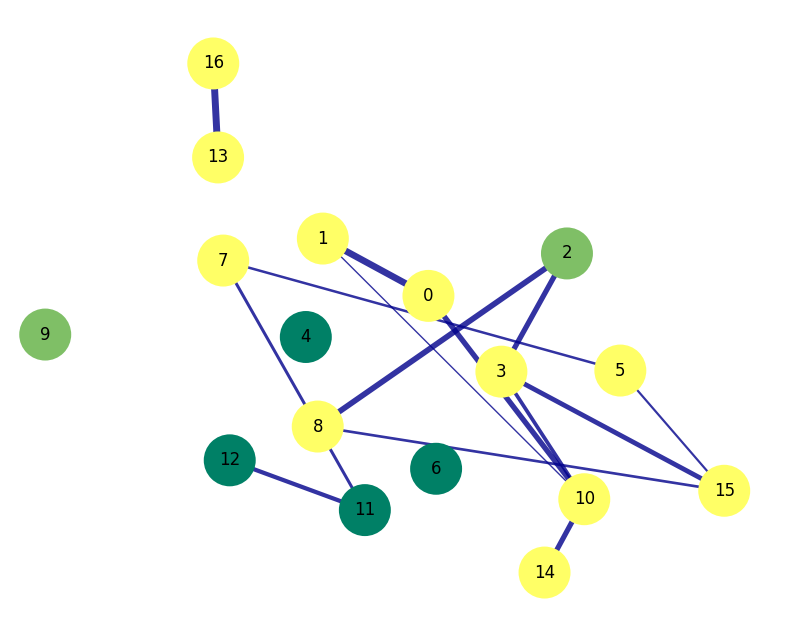

In [9]:
#the precision(inverse covariance) matrix that we want
p = np.around(edge_model.precision_, decimals=3)
p=pd.DataFrame(p)
G, G_complete, _, _ =plot_network(p, 0.3, same_posicion_data, df)

In [10]:
threshold = 0.3
W_pure = p.values.astype(float).copy()
np.fill_diagonal(W_pure, 0.0)
W_pure = np.abs(W_pure)
W_pure[np.abs(W_pure) < threshold] = 0.0
pd.DataFrame(W_pure)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000,0.725,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.623,0.000,0.000,0.000,0.000,0.000,0.000
1,0.725,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.314,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.616,0.0,0.000,0.0,0.000,0.653,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.616,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.497,0.000,0.000,0.000,0.000,0.581,0.000
4,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.403,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.375,0.000
6,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.0,0.403,0.0,0.000,0.000,0.0,0.000,0.441,0.000,0.000,0.000,0.000,0.000
8,0.000,0.000,0.653,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.414,0.000
9,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [11]:
 A_Glasso = minmax_adjacency(W_pure, keep_zeros=True, force_symmetric=True)
 pd.DataFrame(A_Glasso)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.944828,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.710345,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.944828,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.694253,0.0,0.000000,0.0,0.000000,0.779310,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.694253,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.420690,0.000000,0.000000,0.0,0.000000,0.613793,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.204598,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.140230,0.0
6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.0,0.204598,0.0,0.000000,0.000000,0.0,0.000000,0.291954,0.000000,0.0,0.000000,0.000000,0.0
8,0.000000,0.000000,0.779310,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.229885,0.0
9,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


#### Kalofolias

In [13]:
import pygsp
from scipy import spatial
import utils #import utils module from Kalofolias 2016
import learn_graph as lg # import learn_graph module from Kalofolias 2016
from pyunlocbox import functions, solvers

In [14]:
def infer_graph_kalofolias(X, dist_type='correlation', alpha=0.1, beta=1.0):
    """
    X: (N,F) array of signals
    dist_type: 'sqeuclidean' or 'correlation'
    alpha, beta: hyperparámetros de log_degree_barrier
    """
    W_learned, _ = lg.log_degree_barrier(
        X, dist_type=dist_type,
        alpha=alpha, beta=beta,
        retall=True, verbosity='LOW'
    )
    return np.array(W_learned)

#### Correlation

In [15]:
X = df_norm.values

# inference
alpha, beta = 0.5,0.2
W_learned = infer_graph_kalofolias(X, dist_type='correlation',alpha=alpha, beta=beta)

Solution found after 90 iterations:
    objective function f(sol) = 9.981932e+00
    stopping criterion: RTOL


In [16]:
W_df = pd.DataFrame(W_learned)
W_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000e+00,6.208027e-01,5.729209e-06,5.440769e-02,0.000023,0.000019,-0.000025,0.000017,1.130245e-05,0.000006,3.764856e-01,-3.309733e-06,-0.000016,2.404057e-06,-0.000018,3.198246e-07,-1.336027e-06
1,6.208027e-01,0.000000e+00,8.339017e-06,7.340261e-06,0.000026,0.000022,-0.000023,0.000019,1.391226e-05,0.000009,2.154086e-01,-6.999248e-07,-0.000014,5.013865e-06,0.127256,2.929633e-06,1.273781e-06
2,5.729209e-06,8.339017e-06,0.000000e+00,3.227456e-01,0.000021,0.000017,-0.000027,0.000015,6.133305e-01,0.000004,6.347729e-06,-5.243932e-06,-0.000018,4.698575e-07,-0.000020,-1.614375e-06,-3.270226e-06
3,5.440769e-02,7.340261e-06,3.227456e-01,0.000000e+00,0.000020,0.000016,-0.000028,0.000014,8.369498e-06,0.000003,1.812380e-01,-6.242688e-06,-0.000019,-5.288984e-07,-0.000021,4.998633e-01,-4.268982e-06
4,2.342803e-05,2.603784e-05,2.149384e-05,2.049508e-05,0.000000,0.000035,-0.000009,0.000033,2.706708e-05,0.308877,2.404655e-05,1.245489e-05,0.251237,1.816868e-05,-0.000002,1.608445e-05,1.442860e-05
5,1.915406e-05,2.176387e-05,1.721986e-05,1.622111e-05,0.000035,0.000000,0.150983,0.382728,2.279311e-05,0.000018,1.977258e-05,8.180921e-06,-0.000005,1.389471e-05,-0.000006,1.677080e-01,1.015463e-05
6,-2.526453e-05,-2.265472e-05,-2.719873e-05,-2.819748e-05,-0.000009,0.150983,0.000000,0.062908,-2.162548e-05,-0.000027,-2.464601e-05,-3.623767e-05,-0.000049,-3.052388e-05,0.193516,1.826148e-02,-3.426396e-05
7,1.679857e-05,1.940838e-05,1.486437e-05,1.386562e-05,0.000033,0.382728,0.062908,0.000000,2.043762e-05,0.000015,1.741709e-05,2.984322e-01,-0.000007,1.153922e-05,-0.000009,9.454991e-06,7.799139e-06
8,1.130245e-05,1.391226e-05,6.133305e-01,8.369498e-06,0.000027,0.000023,-0.000022,0.000020,0.000000e+00,0.000010,1.192097e-05,3.293120e-07,-0.000013,6.043102e-06,-0.000014,2.136799e-01,2.303018e-06
9,6.314473e-06,8.924281e-06,4.380273e-06,3.381517e-06,0.308877,0.000018,-0.000027,0.000015,9.953518e-06,0.000000,6.932993e-06,8.839347e-02,0.089260,1.055121e-06,-0.000019,-1.029111e-06,-2.684962e-06


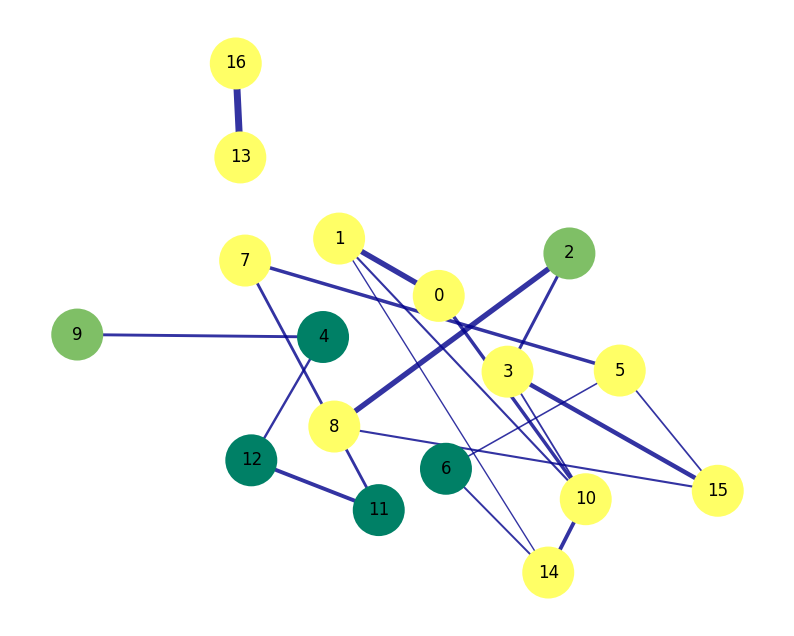

In [17]:
threshold = 0.1  
G, G_complete, _, _ =plot_network(W_df, threshold, same_posicion_data, df) 

In [18]:
W_thresh = W_df.copy()
W_thresh[np.abs(W_thresh) < threshold] = 0.0
pd.DataFrame(W_thresh)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.620803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.376486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.620803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.215409,0.000000,0.000000,0.000000,0.127256,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.322746,0.000000,0.000000,0.000000,0.000000,0.61333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.322746,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.181238,0.000000,0.000000,0.000000,0.000000,0.499863,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.308877,0.000000,0.000000,0.251237,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150983,0.382728,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167708,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.150983,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.193516,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.382728,0.000000,0.000000,0.00000,0.000000,0.000000,0.298432,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.613330,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.213680,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.308877,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
 A_KalofoliasC = minmax_adjacency(W_thresh, keep_zeros=True, force_symmetric=True)
 pd.DataFrame(A_KalofoliasC)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.737658,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372500,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,0.737658,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131753,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.00000,0.292180,0.000000,0.000000,0.000000,0.000000,0.726490,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.000000,0.000000,0.29218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080681,0.000000,0.000000,0.0,0.000000,0.556901,0.0
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.271451,0.000000,0.000000,0.185302,0.0,0.000000,0.000000,0.0
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.035462,0.381830,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.060460,0.0
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.035462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.099033,0.000000,0.0
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.381830,0.000000,0.000000,0.000000,0.000000,0.000000,0.255841,0.000000,0.0,0.000000,0.000000,0.0
8,0.000000,0.000000,0.72649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.129169,0.0
9,0.000000,0.000000,0.00000,0.000000,0.271451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


#### Euclidean distance

In [20]:
X = df_norm.values

alpha, beta = 200,15
W_learned_eu = infer_graph_kalofolias(X, dist_type='sqeuclidean',alpha=alpha, beta=beta)
W_df_eu = pd.DataFrame(W_learned_eu)
W_df_eu 

Solution found after 1000 iterations:
    objective function f(sol) = -2.054749e+03
    stopping criterion: MAXIT


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,1.251800,0.647292,0.846654,0.000375,0.245829,0.130726,0.138535,0.418085,0.086678,1.050155,0.000118,0.000033,0.000306,0.386330,0.617816,0.053043
1,1.251800,0.000000,0.291130,0.658580,0.000400,0.332891,0.000207,0.066978,0.507206,0.000120,0.948156,0.000142,0.000058,0.000330,0.827504,0.548838,0.225111
2,0.647292,0.291130,0.000000,0.848969,0.000384,0.620240,0.000192,0.147601,1.187185,1.242701,0.123002,0.000127,0.016477,0.000315,-0.000009,0.561450,-0.000058
3,0.846654,0.658580,0.848969,0.000000,0.000370,0.437013,0.293741,-0.000083,0.797816,0.000090,0.940654,0.000112,0.000028,0.000300,0.515574,1.027658,-0.000072
4,0.000375,0.000400,0.000384,0.000370,0.000000,0.000343,0.000579,0.209869,0.201442,0.000491,0.000377,0.516673,0.555298,0.000702,0.000378,0.167355,0.000329
5,0.245829,0.332891,0.620240,0.437013,0.000343,0.000000,0.247148,1.068346,0.142221,0.220636,0.120441,0.000086,0.197215,0.179067,-0.000050,0.778512,0.551770
6,0.130726,0.000207,0.000192,0.293741,0.000579,0.247148,0.000000,0.421106,0.000173,0.000299,0.343850,0.000321,0.000237,0.002197,0.408035,0.310386,0.312862
7,0.138535,0.066978,0.147601,-0.000083,0.209869,1.068346,0.421106,0.000000,0.211281,0.258433,0.134571,0.957391,0.885546,0.000249,0.019810,0.293237,0.458198
8,0.418085,0.507206,1.187185,0.797816,0.201442,0.142221,0.000173,0.211281,0.000000,0.546307,0.267687,0.000108,0.000023,0.000296,-0.000029,0.916173,0.045710
9,0.086678,0.000120,1.242701,0.000090,0.000491,0.220636,0.000299,0.258433,0.546307,0.000000,0.000098,0.000234,0.550026,0.000422,0.000098,0.000073,0.321789


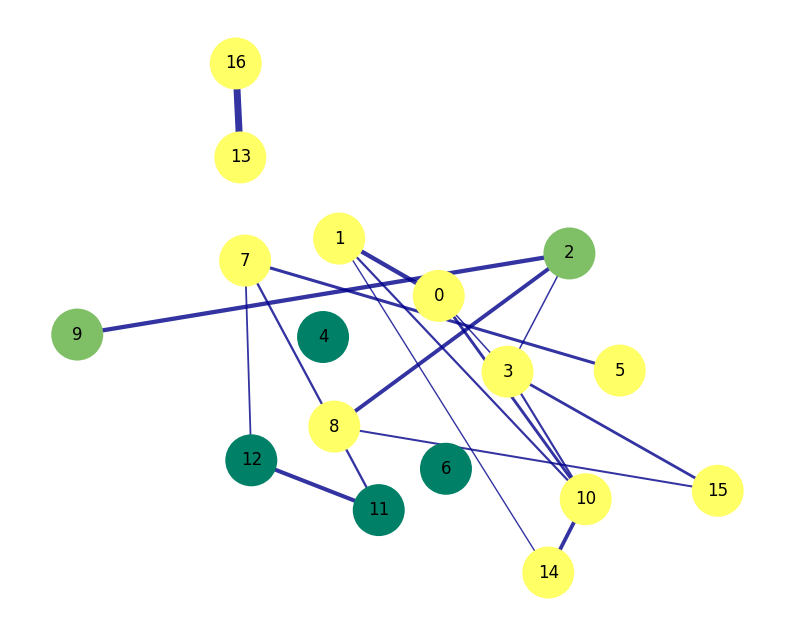

In [21]:
threshold = 0.8   
G_eu, G_complete_eu,_,_ =plot_network(W_df_eu, threshold, same_posicion_data, df) 

In [22]:
W_eu = W_df_eu.copy()
W_eu[np.abs(W_eu) < threshold] = 0.0
pd.DataFrame(W_eu)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,1.251800,0.000000,0.846654,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.050155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.251800,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.948156,0.000000,0.000000,0.000000,0.827504,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.848969,0.0,0.000000,0.0,0.000000,1.187185,1.242701,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.846654,0.000000,0.848969,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.940654,0.000000,0.000000,0.000000,0.000000,1.027658,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.068346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.0,1.068346,0.0,0.000000,0.000000,0.000000,0.000000,0.957391,0.885546,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,1.187185,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.916173,0.000000
9,0.000000,0.000000,1.242701,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
 A_KalofoliasEu = minmax_adjacency(W_eu, keep_zeros=True, force_symmetric=True)
 pd.DataFrame(A_KalofoliasEu)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.531619,0.000000,0.023993,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.278969,0.000000,0.000000,0.0,0.00000,0.000000,0.0
1,0.531619,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.151170,0.000000,0.000000,0.0,0.00000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.026895,0.0,0.000000,0.0,0.000000,0.450659,0.520218,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0
3,0.023993,0.000000,0.026895,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.141770,0.000000,0.000000,0.0,0.00000,0.250781,0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0
5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.301761,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0
6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0
7,0.000000,0.000000,0.000000,0.000000,0.0,0.301761,0.0,0.000000,0.000000,0.000000,0.000000,0.162741,0.072723,0.0,0.00000,0.000000,0.0
8,0.000000,0.000000,0.450659,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.111097,0.0
9,0.000000,0.000000,0.520218,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0


#### KNN

In [24]:
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

In [25]:
def knn_graph(X, k=5, metric='cosine', symmetrize='mutual',
              weighted='gaussian', sigma='median', self_loops=False):
    X = normalize(np.asarray(X, float), norm='l2', axis=1)  
    D = kneighbors_graph(X, n_neighbors=k, mode='distance',
                         metric=metric, include_self=self_loops, n_jobs=-1).tocsr()
    
    D = D.maximum(D.T) if symmetrize == 'union' else D.minimum(D.T)
   
    W = D.copy()
    if weighted == 'binary':
        W.data[:] = 1.0
    elif weighted == 'distance':
        W.data = 1.0 / (W.data + 1e-9)
    elif weighted == 'gaussian':
        d = W.data
        s = (np.median(d) if sigma == 'median' else float(sigma)) or 1.0
        W.data = np.exp(-(d**2)/(2*s**2))
    else:
        raise ValueError("weighted must be 'gaussian' | 'binary' | 'distance'")

    if not self_loops:
        W.setdiag(0.0); W.eliminate_zeros()

   
    L = csgraph_laplacian(W, normed=False)
    L_norm = csgraph_laplacian(W, normed=True)
    return W, L, L_norm

In [26]:
def knn_similarity_df(X, k=4, metric='cosine', symmetrize='mutual',
                      weighted='gaussian', sigma='median', node_ids=None):
    W, _, _ = knn_graph(X, k=k, metric=metric, symmetrize=symmetrize,
                        weighted=weighted, sigma=sigma)
    A = W.toarray()
    np.fill_diagonal(A, 0.0)
    n = A.shape[0]

    if node_ids is None:
        node_ids = np.arange(n)  # 0,1,2,...,n-1
    return pd.DataFrame(A, index=node_ids, columns=node_ids)

/opt/anaconda3/envs/pyunlocbox-env/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


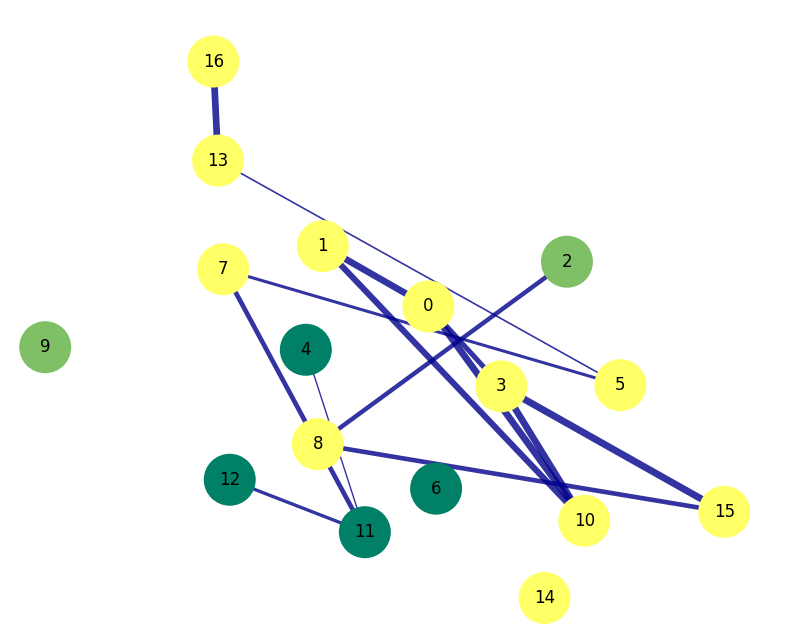

In [27]:
matrix_knn = knn_similarity_df(X, k=3, metric='cosine',
                               symmetrize='mutual', weighted='gaussian', sigma='median')

G_knn, G_all, _, _ = plot_network(matrix_knn,0.1,same_posicion_data,df) 


In [28]:
matrix_knn

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.726266,0.000000,0.619009,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.733420,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.726266,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.688482,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.577268,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.619009,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.731986,0.000000,0.000000,0.000000,0.0,0.746531,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.370966,0.000000,0.000000,0.0,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.483081,0.000000,0.0,0.000000,0.000000,0.000000,0.388044,0.0,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.483081,0.0,0.000000,0.000000,0.0,0.000000,0.594052,0.000000,0.000000,0.0,0.000000,0.000000
8,0.000000,0.000000,0.577268,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.588603,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [29]:
 A_KNN = minmax_adjacency(matrix_knn, keep_zeros=True, force_symmetric=True)
 pd.DataFrame(A_KNN)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.946040,0.00000,0.660452,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.965090,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.946040,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.845434,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.549310,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.660452,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.961272,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.298521,0.000000,0.0,0.000000,0.000000,0.000000,0.045473,0.0,0.000000,0.000000
6,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.000000,0.0,0.298521,0.0,0.000000,0.000000,0.0,0.000000,0.594001,0.000000,0.000000,0.0,0.000000,0.000000
8,0.000000,0.000000,0.54931,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.579491,0.000000
9,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


### Results

### Unsupervised model selection criterion

In [30]:
def reconstruccion_xnodos_cv_NMSE(X, A, porcentajes, lambda_reg, num_folds=100):
    """
     Perform an iterative reconstruction by testing different percentages of nodes
     using cross-validation to calculate the mean and standard deviation of the NMSE.

    Args:
        X (numpy.ndarray): Feature matrix (NxF).
        A (numpy.ndarray): Adjacency matrix (NxN).
        percentages (list): List of percentages of nodes to reconstruct (10%, 20%, ..., 80%).
        lambda_reg (float): Regularization value.
        num_folds (int): Number of folds for the cross validation.

    Returns:
       Results with percentages, mean NMSE and standard deviation.
    """
    resultados = []
    G = nx.from_numpy_array(A) 
    L = nx.laplacian_matrix(G).toarray()  
    
    nodos_totales = list(G.nodes)
    
    error_fold_results = {porcentaje: [] for porcentaje in porcentajes}

    for fold in range(num_folds):
        for porcentaje in porcentajes:
            num_nodos_reconstruir = max(1, int(len(nodos_totales) * (porcentaje / 100)))

            nodos_reconstruir = random.sample(nodos_totales, num_nodos_reconstruir)

            # J
            J = np.ones_like(X)
            for nodo in nodos_reconstruir:
                J[nodo, :] = 0  

        
            X_tilde = cp.Variable(X.shape)

            trace_term = sum(cp.quad_form(X_tilde[:, i], L) for i in range(X.shape[1]))
            objective = cp.Minimize(cp.norm(cp.multiply(J, X_tilde - X), "fro") ** 2 + lambda_reg * trace_term)

            problem = cp.Problem(objective)
            problem.solve()

            X_tilde_result = X_tilde.value
            error = np.linalg.norm(X - X_tilde_result, 'fro') / np.linalg.norm(X, 'fro')
            error_fold_results[porcentaje].append(error)

    # mean and STD
    resumen_resultados = []
    for porcentaje in porcentajes:
        error_mean = np.mean(error_fold_results[porcentaje])
        error_std = np.std(error_fold_results[porcentaje])
        resumen_resultados.append({
            "Percentage": porcentaje,
            "Error_Mean": error_mean,
            "Error_Desviacion": error_std
        })

    
    df_resultados = pd.DataFrame(resumen_resultados)

   
    plt.figure(figsize=(8, 6))
    plt.plot(df_resultados["Percentage"], df_resultados["Error_Mean"], 
             marker='o', linestyle='-', linewidth=2, label="Median ")
    plt.fill_between(
        df_resultados["Percentage"],
        df_resultados["Error_Mean"] - df_resultados["Error_Desviacion"],
        df_resultados["Error_Mean"] + df_resultados["Error_Desviacion"],
        color='gray', alpha=0.3, label="STD"
    )
    plt.xlabel("Node Reconstruction (%)", fontsize=12)
    plt.ylabel("Normalized MSE (Frobenius)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(-0.1, 1.0)
    plt.legend()
    plt.show()

    return df_resultados, error_fold_results

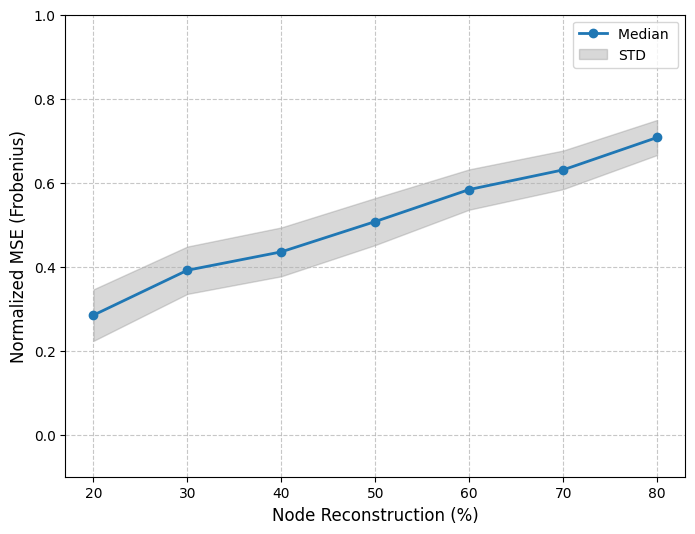

   Percentage  Error_Mean  Error_Desviacion
0          20    0.284723          0.061337
1          30    0.391643          0.056388
2          40    0.435387          0.058164
3          50    0.507577          0.055990
4          60    0.583798          0.047996
5          70    0.630599          0.046022
6          80    0.707703          0.041729


In [32]:
# Glasso
porcentajes = [20, 30, 40, 50, 60, 70, 80]
lambda_reg = 0.01
num_folds = 100
X = df_norm.values # NxF
A = A_Glasso # NxN adjacency matrix from Glasso

df_resultados_cv, mse_fold_results = reconstruccion_xnodos_cv_NMSE(X, A, porcentajes, lambda_reg, num_folds)

print(df_resultados_cv)

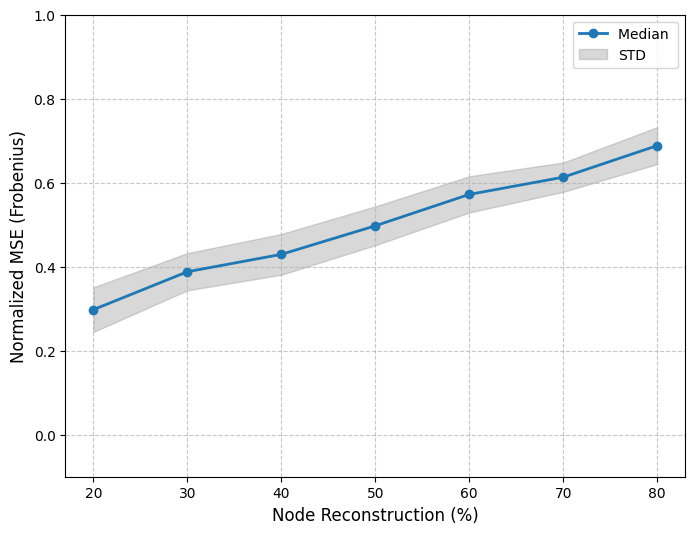

   Percentage  Error_Mean  Error_Desviacion
0          20    0.297896          0.053137
1          30    0.388072          0.044316
2          40    0.429440          0.048552
3          50    0.497402          0.046190
4          60    0.572141          0.043216
5          70    0.613126          0.034957
6          80    0.688280          0.043958


In [33]:
#  Kalofolias correlation

porcentajes = [20, 30, 40, 50, 60, 70, 80]
lambda_reg = 0.01
num_folds = 100
X = df_norm.values # NxF
A = A_KalofoliasC # NxN adjacency matrix from Kalofolias correlation


df_resultados_cv, mse_fold_results = reconstruccion_xnodos_cv_NMSE(X, A, porcentajes, lambda_reg, num_folds)

print(df_resultados_cv)

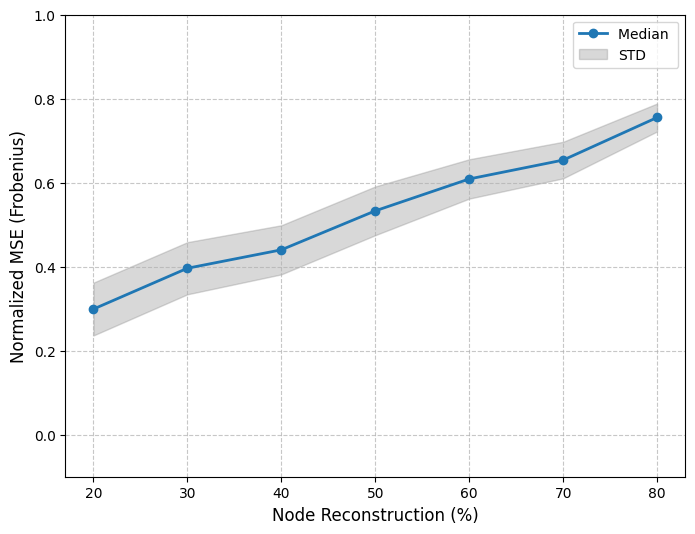

   Percentage  Error_Mean  Error_Desviacion
0          20    0.299186          0.062882
1          30    0.396370          0.062074
2          40    0.440232          0.058450
3          50    0.533057          0.058024
4          60    0.608964          0.046821
5          70    0.653929          0.043515
6          80    0.755293          0.033267


In [36]:
#  Kalofolias Euclidean distance

porcentajes = [20, 30, 40, 50, 60, 70, 80]
lambda_reg = 0.01
num_folds = 100
X = df_norm.values # NxF
A = A_KalofoliasEu # NXN adjacency matrix from Kalofolias Euclidean distance

df_resultados_cv, mse_fold_results = reconstruccion_xnodos_cv_NMSE(X, A, porcentajes, lambda_reg, num_folds)

print(df_resultados_cv)

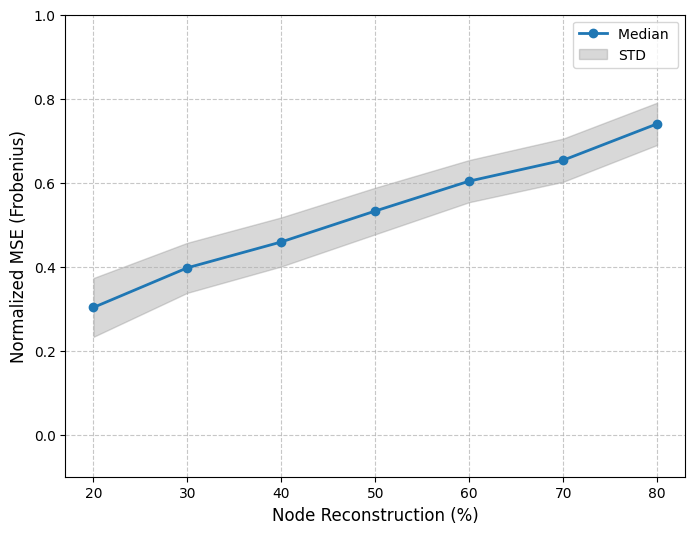

   Percentage  Error_Mean  Error_Desviacion
0          20    0.303043          0.070009
1          30    0.397462          0.059594
2          40    0.459026          0.058435
3          50    0.532656          0.055467
4          60    0.603821          0.050188
5          70    0.653600          0.051453
6          80    0.740219          0.050333


In [37]:
#  KNN

porcentajes = [20, 30, 40, 50, 60, 70, 80]
lambda_reg = 0.01
num_folds = 100
X = df_norm.values # NxF
A = A_KNN # NXN adjacency matrix from KNN

df_resultados_cv, mse_fold_results = reconstruccion_xnodos_cv_NMSE(X, A, porcentajes, lambda_reg, num_folds)


print(df_resultados_cv)

Processing matrix: Glasso


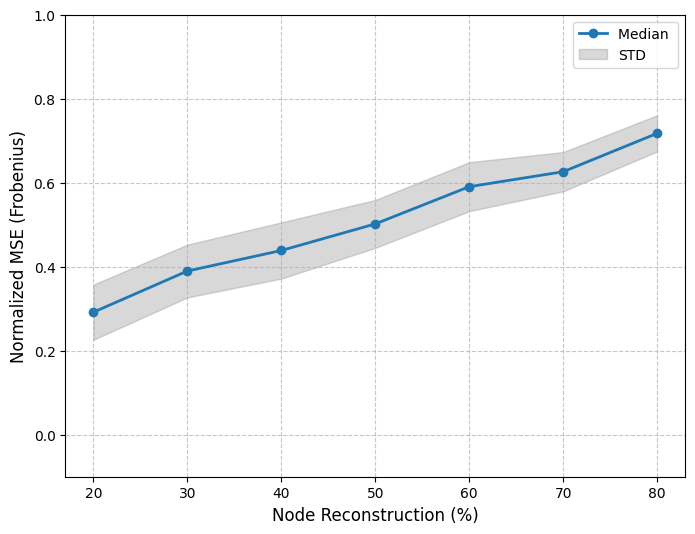

Processing matrix: Kalofolias


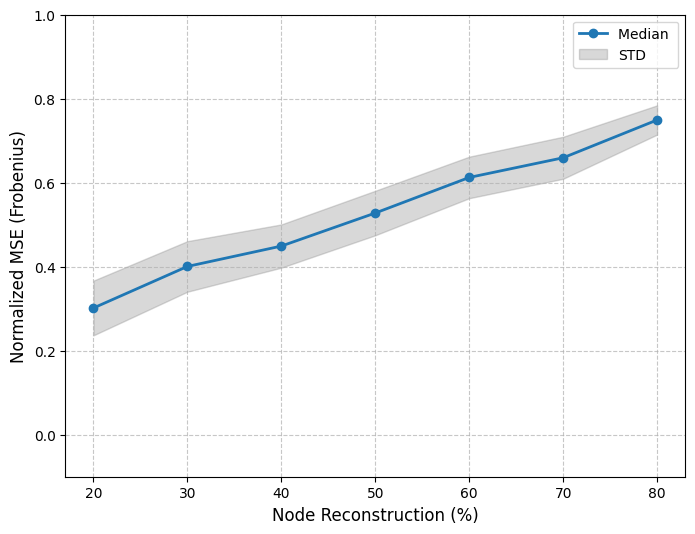

Processing matrix: Kalofolias Correlation


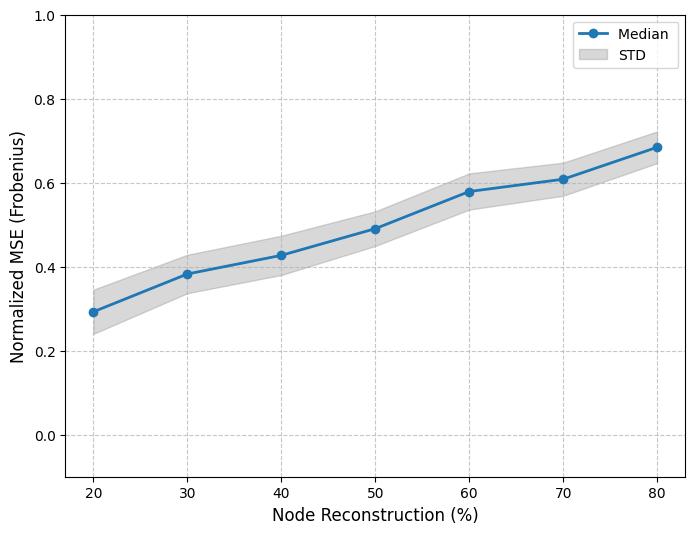

Processing matrix: KNN


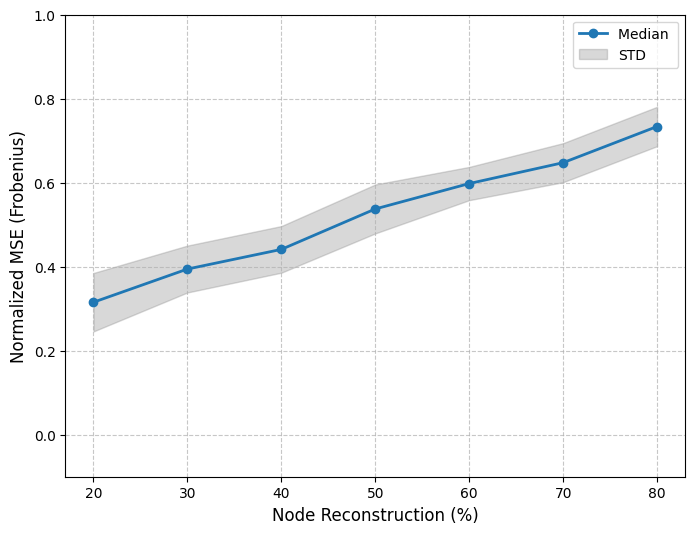

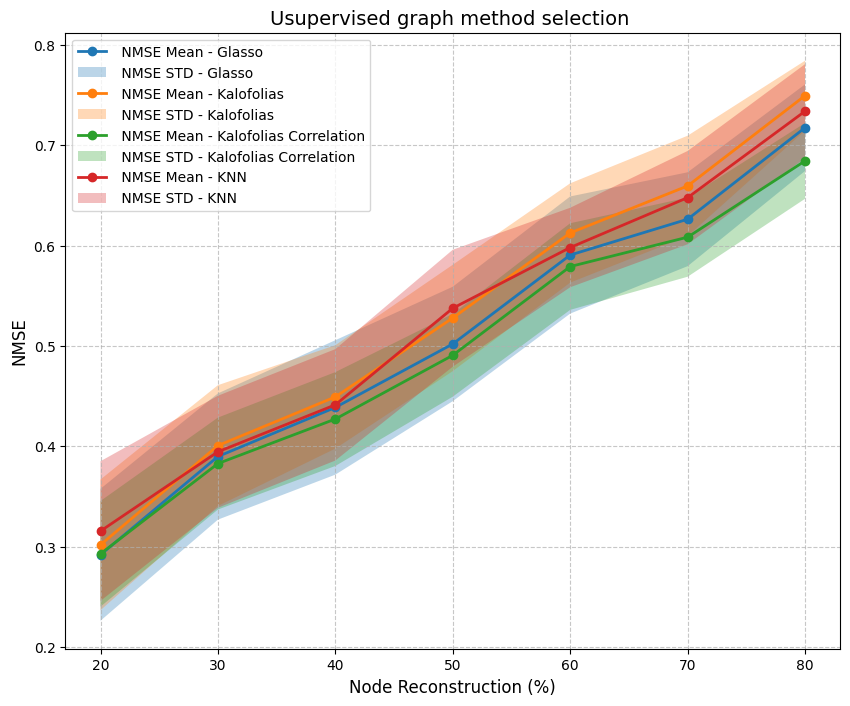

In [38]:
# Abliation graphic
factor_mse = None    # None => NO se escala la MSE, p.ej. 100 => multiplicar por 100
use_logscale = False   # False => Eje Y normal, True => Eje Y en escala log
     
# Matrices resultado
matrices = {

    "Glasso": A_Glasso,  
    "Kalofolias":A_KalofoliasEu,
    "Kalofolias Correlation": A_KalofoliasC,
    "KNN": A_KNN
}

porcentajes = [20, 30, 40, 50, 60, 70, 80]
lambda_reg = 0.01
num_folds = 100
X = df_norm.values  # NxF

resultados_matrices = {}

for nombre, matriz in matrices.items():
    print(f"Processing matrix: {nombre}")
    df_resultados_cv, mse_fold_results = reconstruccion_xnodos_cv_NMSE(
        X, matriz, porcentajes, lambda_reg, num_folds
    )
    resultados_matrices[nombre] = df_resultados_cv

plt.figure(figsize=(10, 8))

for nombre, resultados in resultados_matrices.items():
    y_mean = resultados["Error_Mean"].copy()
    y_std = resultados["Error_Desviacion"].copy()

    # scale if needed
    if factor_mse is not None:
        y_mean *= factor_mse
        y_std *= factor_mse

    label_mean = f" NMSE Mean - {nombre}" if factor_mse is None else f"NMSE Mean (x{factor_mse}) - {nombre}"
    label_std = f" NMSE STD - {nombre}" if factor_mse is None else f"NMSE STD (x{factor_mse}) - {nombre}"

    plt.plot(
        resultados["Percentage"],
        y_mean,
        marker='o', linestyle='-', linewidth=2,
        label=label_mean
    )

    plt.fill_between(
      resultados["Percentage"],
      y_mean - y_std,
      y_mean + y_std,
      alpha=0.3,
      label=label_std
    )

# log scale if needed
if use_logscale:
    plt.yscale('log')


titulo = "Usupervised graph method selection "
if factor_mse is not None:
    titulo += f" (Escalado x{factor_mse})"
if use_logscale:
    titulo += " [Escala Log]"

plt.title(titulo, fontsize=14)
plt.xlabel("Node Reconstruction (%)", fontsize=12)
plt.ylabel("NMSE" if factor_mse is None else f"NMSE (x{factor_mse})", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
#plt.savefig("soundscape_graphs_grid.svg", format="svg", bbox_inches="tight")
plt.show()